# Homework 4
*Ahmet Sualp Say - IE48B - Fall 2021*

In [1]:
require(data.table)
require(lubridate)
require(forecast)
require(ggplot2)
require(repr)
require(rpart)
require(rattle)
require(performance)

options(repr.plot.width=15, repr.plot.height=8)
options(warn=-1)

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: ggplot2

Loading required package: repr

Loading required package: rpart

Warning message:
"package 'rpart' was built under R version 3.6.3"
Loading required package: rattle

Warning message:
"package 'rattle' was built under R version 3.6.3"
Loading required package: tibble

Warning message:
"package 'tibble' was built under R version 3.6.3"
Loading required package: bitops

Warning message:
"package 'bitops' was built under R version 3.6.3"
Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.

Loading required package: performance



### Task: Prediction of total solar power plan production values

Your ultimate task will be to forecast hourly solar power production for the period between start of the November, 2021 until the end of the data (i.e. 2021-11-01 to 2021-12-25 both included) under the mentioned scenario (i.e. we know the production values up to d-1 and willing to forecast the hourly levels for d+1) by using the regression tree-based approach (namely EBLR).

In [2]:
current_folder = getwd()

dat = fread('production_with_weather_data.csv')

In [3]:
# there are some missing columns in data, so we need to ignore them first
dat[!complete.cases(dat)]

date,hour,production,DSWRF_surface_38_35,DSWRF_surface_38_35.25,DSWRF_surface_38_35.5,DSWRF_surface_38_35.75,DSWRF_surface_38_36,DSWRF_surface_38.25_35,DSWRF_surface_38.25_35.25,...,TMP_2.m.above.ground_38.75_35,TMP_2.m.above.ground_38.75_35.25,TMP_2.m.above.ground_38.75_35.5,TMP_2.m.above.ground_38.75_35.75,TMP_2.m.above.ground_38.75_36,TMP_2.m.above.ground_39_35,TMP_2.m.above.ground_39_35.25,TMP_2.m.above.ground_39_35.5,TMP_2.m.above.ground_39_35.75,TMP_2.m.above.ground_39_36
2021-06-09,19,7.901200,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021-11-26,14,189.840300,NA,NA,NA,NA,NA,NA,NA,...,284.835,284.405,283.225,282.735,282.425,283.215,283.015,282.375,282.495,282.715
2021-11-26,16,35.422200,272.98,269.88,235.88,183.32,79.18,260.46,251.68,...,285.017,284.447,283.517,282.757,282.217,283.637,283.197,282.347,282.457,282.957
2021-12-01,7,0.260118,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021-12-13,0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021-12-22,18,0.000000,NA,NA,NA,NA,NA,NA,NA,...,269.097,269.567,268.067,263.837,264.207,268.907,269.037,268.077,267.567,267.297
2021-12-25,16,46.846580,NA,NA,NA,NA,NA,NA,NA,...,275.997,275.377,275.497,271.187,269.877,274.217,274.307,273.747,273.017,273.247


In [4]:
dat = dat[complete.cases(dat)]

In [5]:
head(dat)

date,hour,production,DSWRF_surface_38_35,DSWRF_surface_38_35.25,DSWRF_surface_38_35.5,DSWRF_surface_38_35.75,DSWRF_surface_38_36,DSWRF_surface_38.25_35,DSWRF_surface_38.25_35.25,...,TMP_2.m.above.ground_38.75_35,TMP_2.m.above.ground_38.75_35.25,TMP_2.m.above.ground_38.75_35.5,TMP_2.m.above.ground_38.75_35.75,TMP_2.m.above.ground_38.75_36,TMP_2.m.above.ground_39_35,TMP_2.m.above.ground_39_35.25,TMP_2.m.above.ground_39_35.5,TMP_2.m.above.ground_39_35.75,TMP_2.m.above.ground_39_36
2019-09-01,0,0.0000,0,0,0,0,0,0,0,...,290.800,289.800,290.800,289.600,289.200,290.700,289.800,289.100,290.300,290.500
2019-09-01,1,0.0000,0,0,0,0,0,0,0,...,289.900,289.200,290.100,288.700,288.400,289.900,288.800,288.500,289.500,289.700
2019-09-01,2,0.0000,0,0,0,0,0,0,0,...,289.300,288.600,289.700,288.100,287.800,289.400,288.100,287.900,288.900,289.200
2019-09-01,3,0.0000,0,0,0,0,0,0,0,...,288.700,288.100,289.200,287.600,287.300,288.800,287.500,287.300,288.400,288.500
2019-09-01,4,0.0000,0,0,0,0,0,0,0,...,288.096,287.596,288.596,286.996,286.696,288.296,286.696,286.596,287.596,287.796
2019-09-01,5,0.1912,0,0,0,0,0,0,0,...,287.517,286.917,287.817,286.517,286.217,287.617,286.017,285.817,287.017,287.217


In [6]:
# there are some hours no power is produced, probably this is due to night time 
summary(dat)

     date                hour        production       DSWRF_surface_38_35
 Length:20273       Min.   : 0.0   Min.   :  0.0000   Min.   :  0.0      
 Class :character   1st Qu.: 5.0   1st Qu.:  0.0004   1st Qu.:  0.0      
 Mode  :character   Median :11.0   Median :  1.4343   Median : 76.0      
                    Mean   :11.5   Mean   : 67.5338   Mean   :222.6      
                    3rd Qu.:17.0   3rd Qu.:128.0000   3rd Qu.:410.0      
                    Max.   :23.0   Max.   :330.3170   Max.   :970.0      
 DSWRF_surface_38_35.25 DSWRF_surface_38_35.5 DSWRF_surface_38_35.75
 Min.   :  0.00         Min.   :  0.0         Min.   :  0.0         
 1st Qu.:  0.00         1st Qu.:  0.0         1st Qu.:  0.0         
 Median : 74.36         Median : 64.4         Median : 60.0         
 Mean   :221.19         Mean   :217.1         Mean   :214.6         
 3rd Qu.:403.92         3rd Qu.:396.2         3rd Qu.:390.0         
 Max.   :970.00         Max.   :960.0         Max.   :960.0         

In [7]:
dat[,base_prediction:=shift(production, n=48, type="lag")]

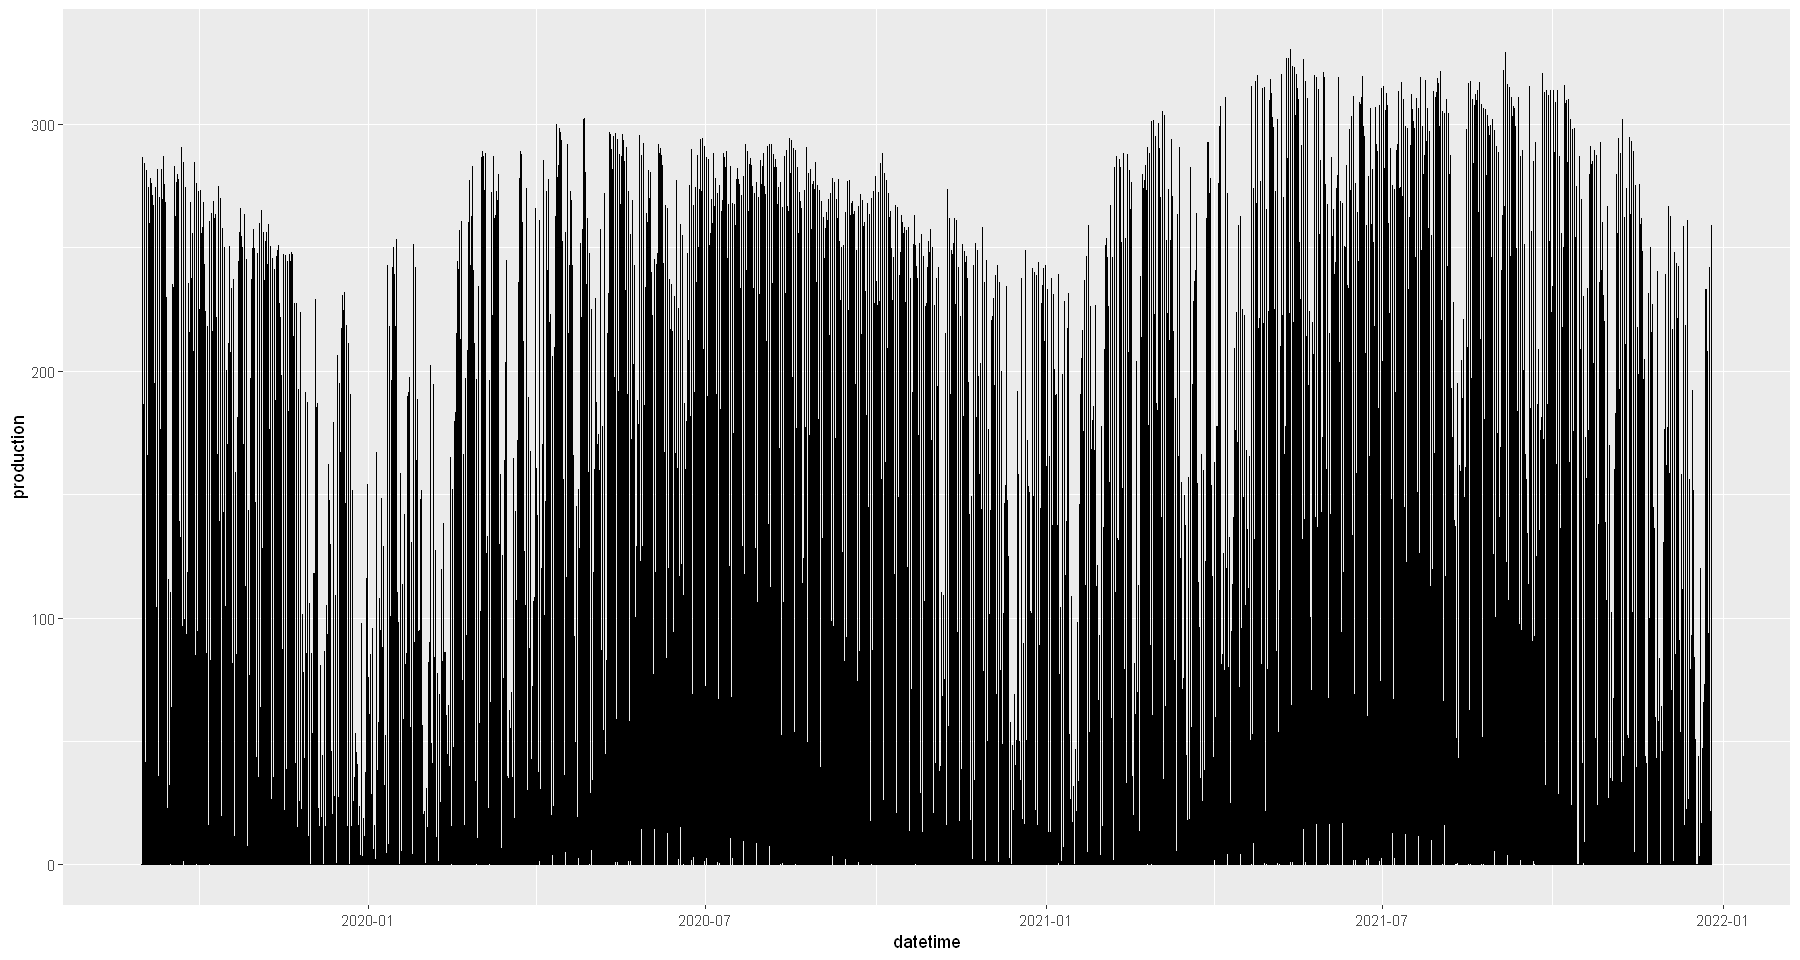

In [8]:
# firt visualize the hourly production to gather some information about characteristic of the problem
dat[,datetime:=ymd(date) + dhours(hour)]

# make sure data is ordered
dat = dat[order(datetime)] 

ggplot(dat, aes(x=datetime, y=production)) + geom_line()

In [9]:
lm_models = list()
lm_predictions = list()

# preprocess the data to model
dat[,trend:=1:.N]
dat[,hour:=as.factor(hour)]
dat[,w_day:=as.character(wday(datetime,label=T))]
dat[,mon:=as.character(month(datetime,label=T))]

iter=1
for (day in unique(dat[date>="2021-11-01",]$date)){
            
    # suppose you are at day d and the predictions are needed for day d+1 and you know the production values until the end of d-1
    train_dat = dat[date<as.Date(day)-2]
    test_dat = dat[date==as.Date(day)]
    
    # model data
    lm_base = lm(production ~ trend + w_day + mon + hour, train_dat)
    test_dat[,lm_base_prediction:=predict(lm_base, test_dat)]
    test_dat[,lm_base_prediction:=ifelse(lm_base_prediction<0, 0, lm_base_prediction)]
    
    # store models and predictions
    lm_models[[iter]] = lm_base
    lm_predictions[[iter]] = test_dat
    iter=iter+1
    
}

fitted_values_lm = do.call(rbind, lm_predictions)
fitted_values_lm = fitted_values_lm[,c("date", "datetime", "hour", "production", "base_prediction", "lm_base_prediction")]

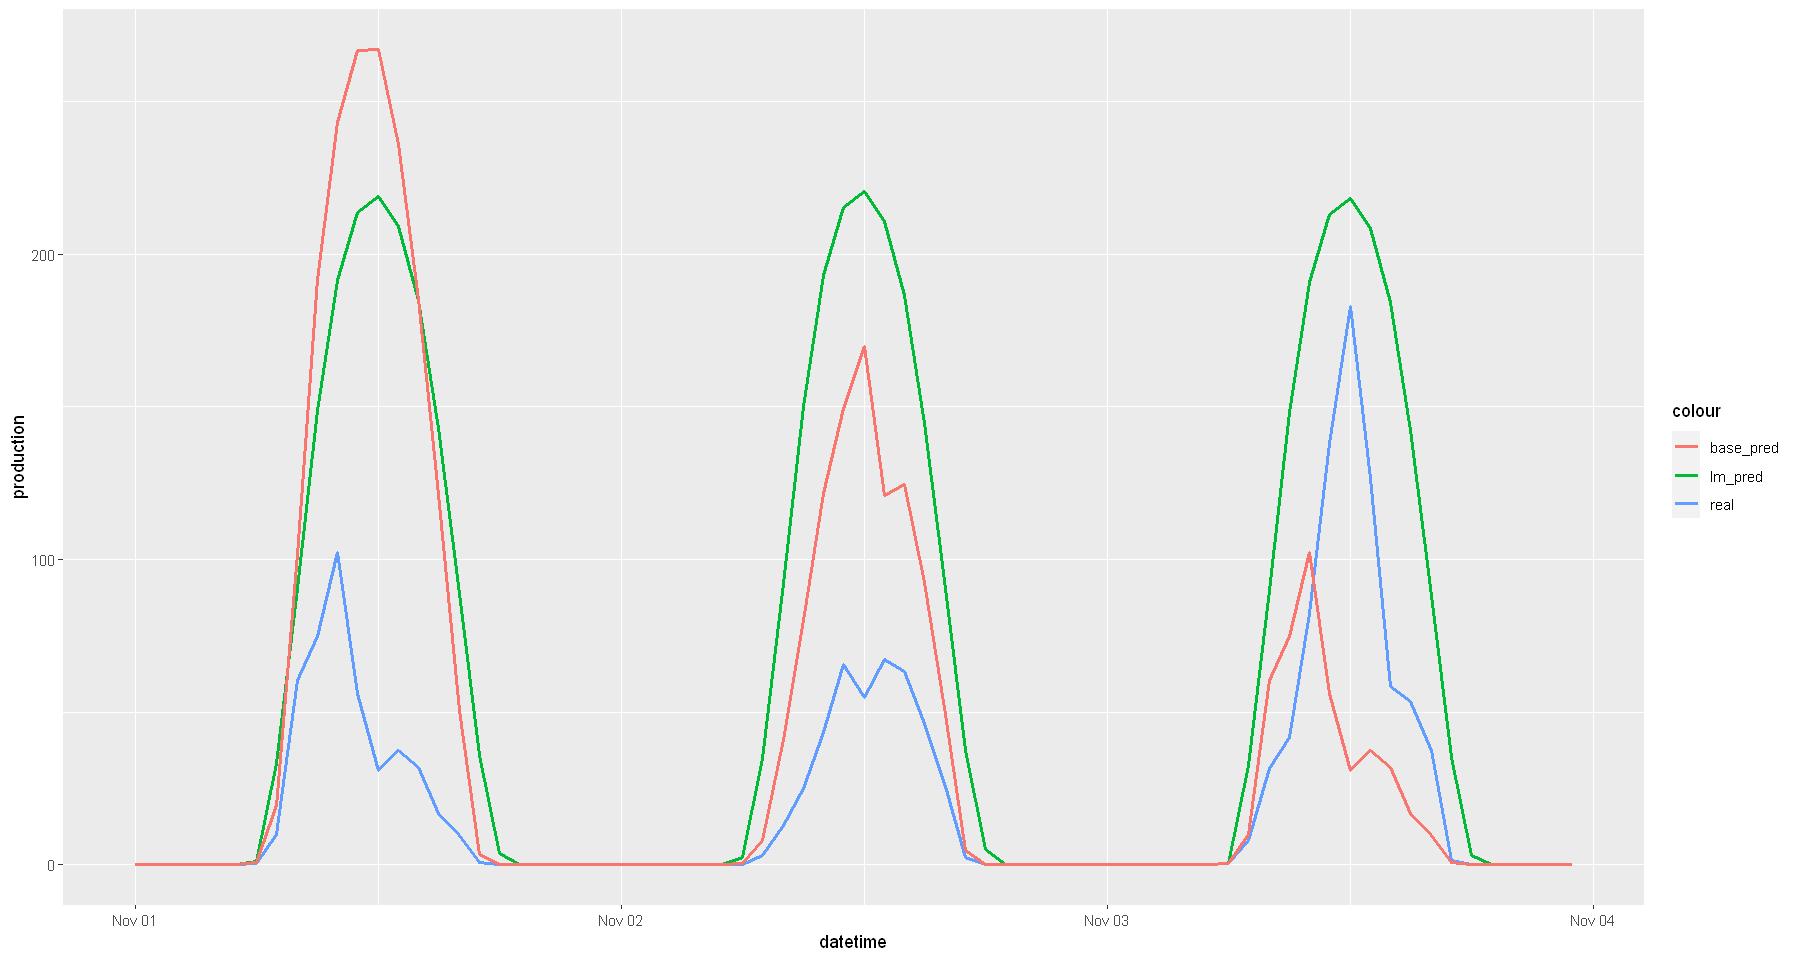

In [10]:
# visualize the three days prediction
ggplot(fitted_values_lm[date>="2021-11-01"&date<="2021-11-03",] ,aes(x=datetime)) +
        geom_line(aes(y=production, color='real'), size=1) + 
        geom_line(aes(y=lm_base_prediction, color='lm_pred'), size=1) +
        geom_line(aes(y=base_prediction, color='base_pred'), size=1)

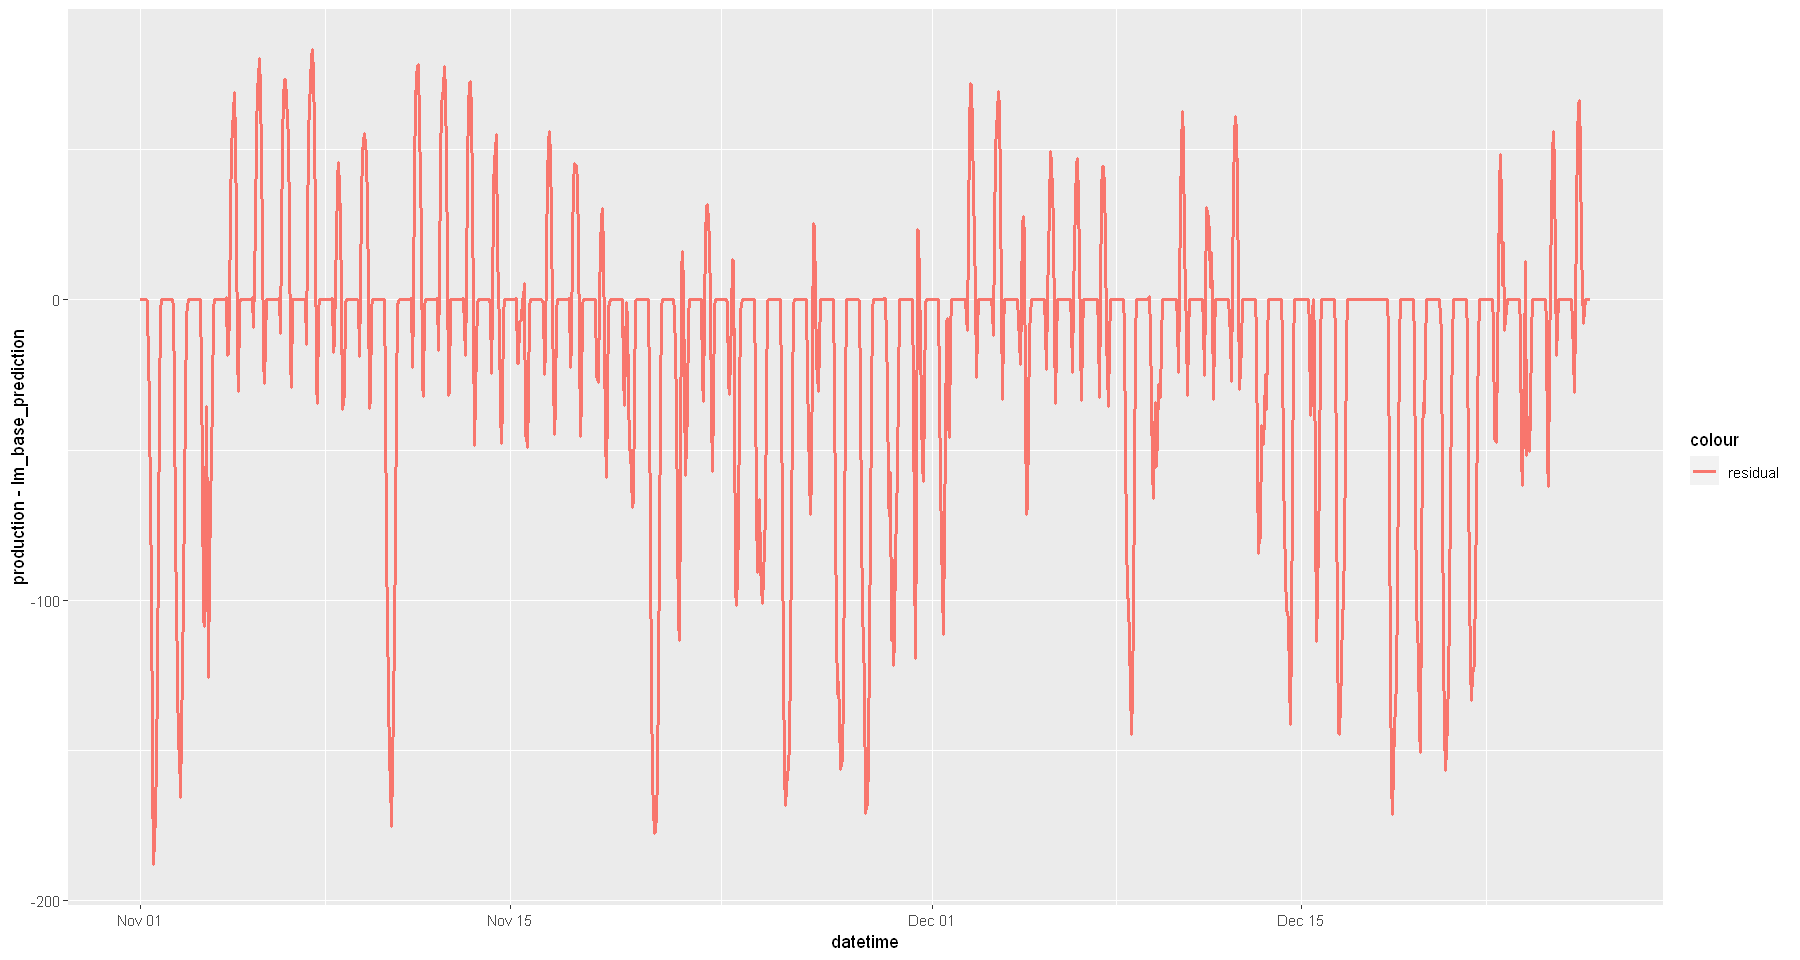

In [11]:
# plot residuals 
ggplot(fitted_values_lm ,aes(x=datetime)) +
        geom_line(aes(y=production-lm_base_prediction,color='residual'), size=1)

In [12]:
# fit eblr model

day="2021-09-01" # where prediction period starts
train_dat = dat[date<as.Date(day)-2]

# model data, use first model to fit eblr
lm_base = lm_models[[1]]

# fit on train data and calculate residuals
train_dat[,lm_base_prediction:=predict(lm_base, train_dat)]
train_dat[,lm_base_prediction:=ifelse(lm_base_prediction<0, 0, lm_base_prediction)]
train_dat[,residual_base:=production-lm_base_prediction]
    

# create formula
variables = colnames(train_dat[, -c("date", "production", "datetime","base_prediction", "trend", "lm_base_prediction", "residual_base")])
formula = as.formula(paste("residual_base", 
            paste(variables, collapse = " + "), 
            sep = " ~ "))
    
# fit regression tree on residuals
fit_res_tree = rpart(formula, train_dat, control=rpart.control(cp=0, maxdepth=4))

In [13]:
# see performance of the base model, in terms of provided measure
performance = train_dat[,list(daily_production=sum(production),
                              daily_prediction=sum(lm_base_prediction),
                              daily_residual=sum(production)-sum(lm_base_prediction)), "date"]

performance[,ape:=abs(daily_residual)/daily_production]
print(sprintf("current wmape: %.3f percent", 100*sum(abs(performance$daily_residual))/sum(performance$daily_production)))

[1] "current wmape: 22.773 percent"


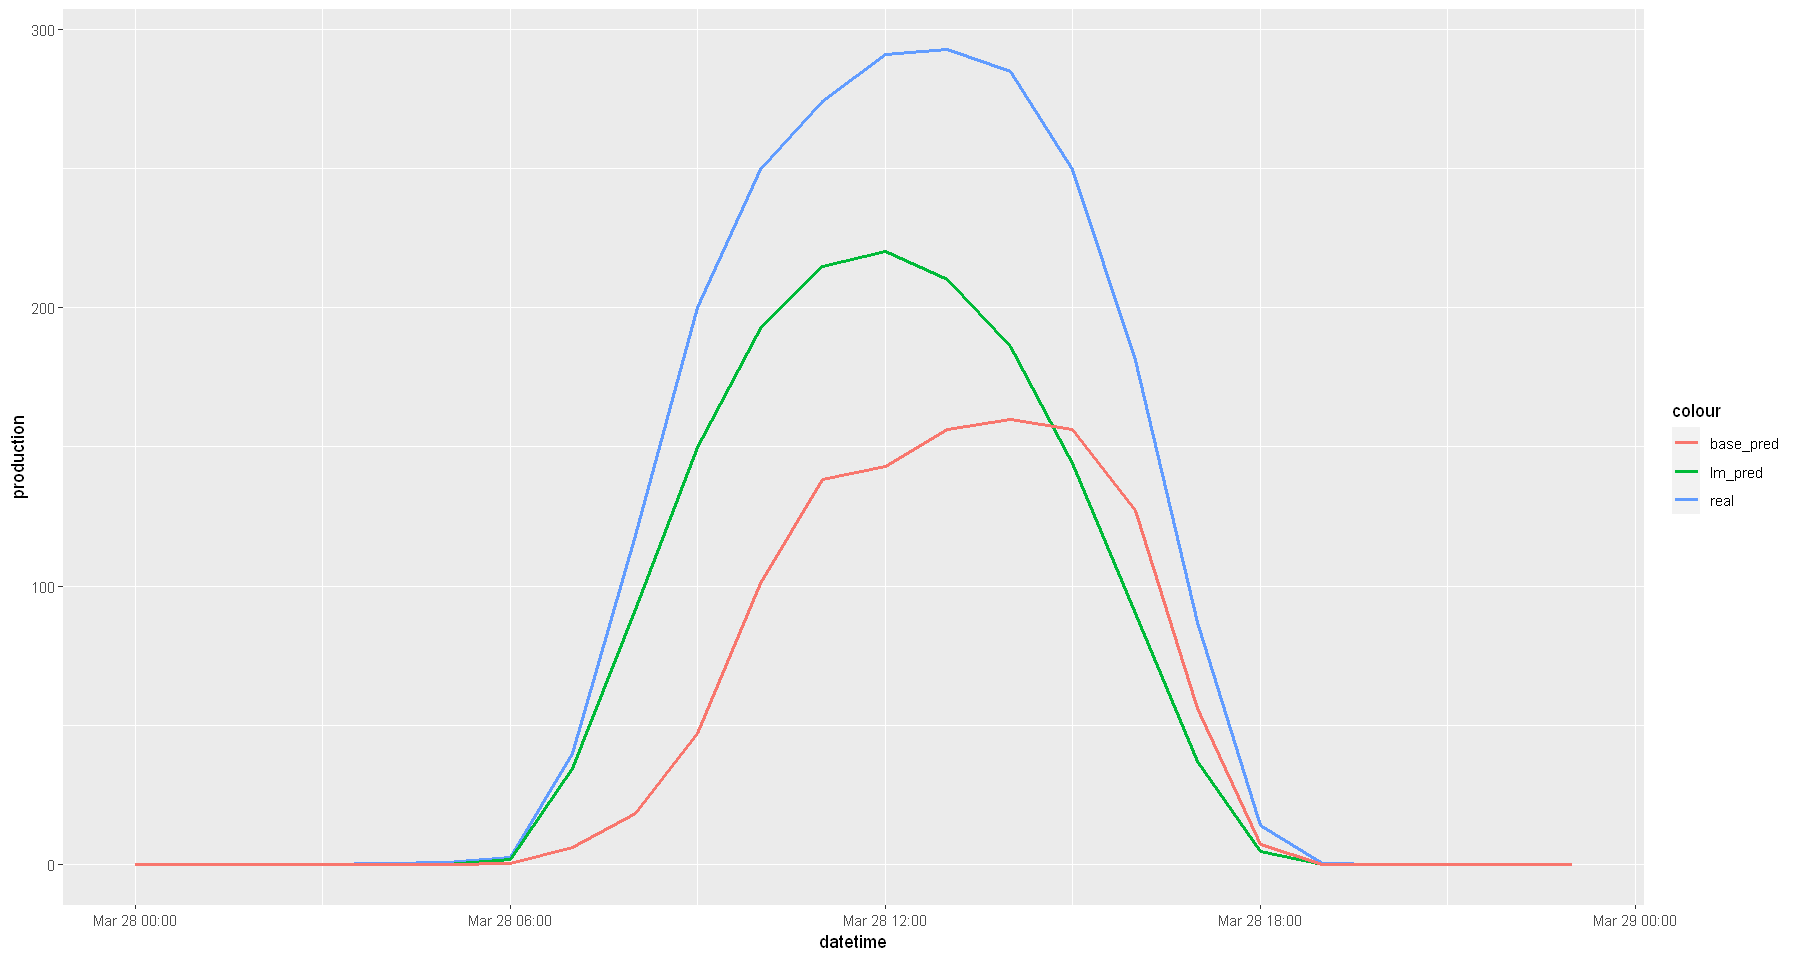

In [14]:
# check the date we make huge mistake and compare after eblr fit
ggplot(train_dat[date=="2021-03-28"] ,aes(x=datetime)) +
        geom_line(aes(y=production, color='real'), size=1) + 
        geom_line(aes(y=lm_base_prediction, color='lm_pred'), size=1) +
        geom_line(aes(y=base_prediction, color='base_pred'), size=1)

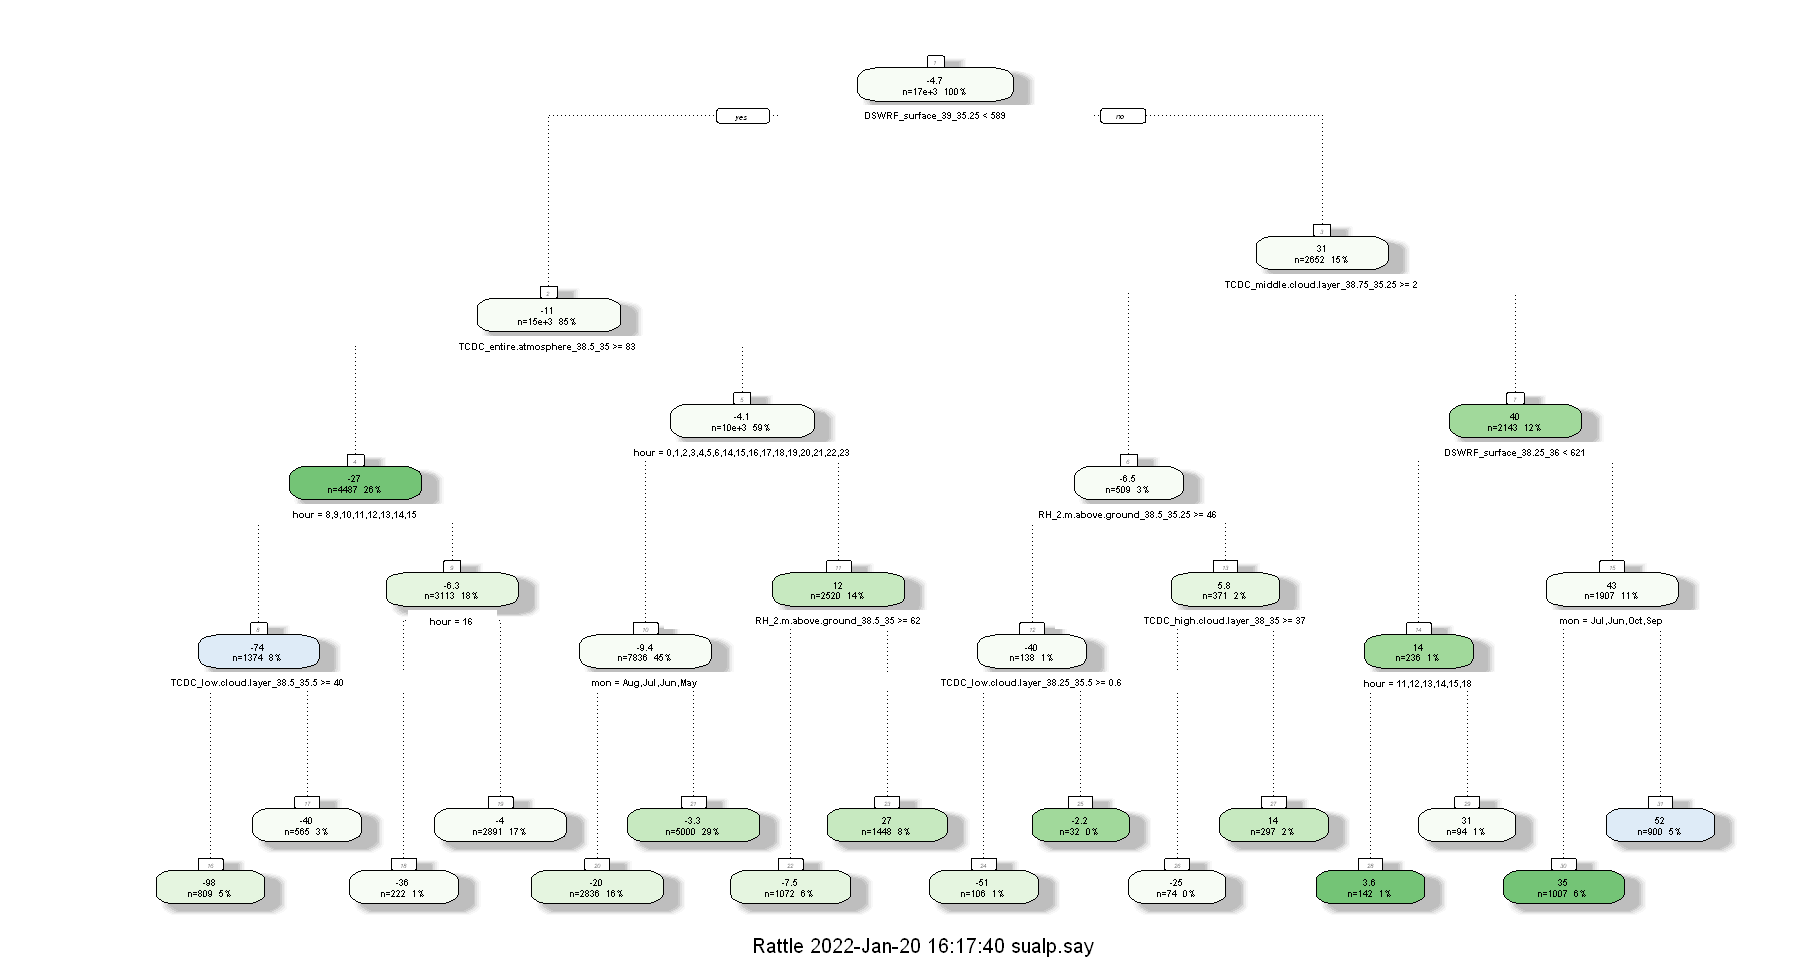

In [15]:
fancyRpartPlot(fit_res_tree)

###### Rules for terminal nodes with the largest absolute error: DSWRF_surface_39_35.25>589, TCDC_middle.cloud.layer_38.75_35.25<2, DSWRF_surface_38.25_36>621, mon!=Jul, Jun, Oct, Sep

In [16]:
train_dat[,rule1:=as.numeric(DSWRF_surface_39_35.25>=589)]
train_dat[,rule1.1:=as.numeric(TCDC_middle.cloud.layer_38.75_35.25<2)]
train_dat[,rule1.2:=as.numeric(DSWRF_surface_38.25_36>=621)]
train_dat[,rule1.3:=as.numeric(!(mon %in% c('Jul', 'Jun', 'Oct', 'Sep')))]

lm_eblr_1 = lm(production ~ trend + w_day + mon + hour+rule1*rule1.1*rule1.2*rule1.3, train_dat)
train_dat[,lm_eblr_prediction_1:=predict(lm_eblr_1, train_dat)]
train_dat[,lm_eblr_prediction_1:=ifelse(lm_eblr_prediction_1<0, 0, lm_eblr_prediction_1)]

In [17]:
# see performance of the eblr model, in terms of provided measure
performance = train_dat[,list(daily_production=sum(production),
                              daily_prediction=sum(lm_eblr_prediction_1),
                              daily_residual=sum(production)-sum(lm_eblr_prediction_1)), "date"]

performance[,ape:=abs(daily_residual)/daily_production]
print(sprintf("current wmape: %.3f percent", 100*sum(abs(performance$daily_residual))/sum(performance$daily_production)))

[1] "current wmape: 14.772 percent"


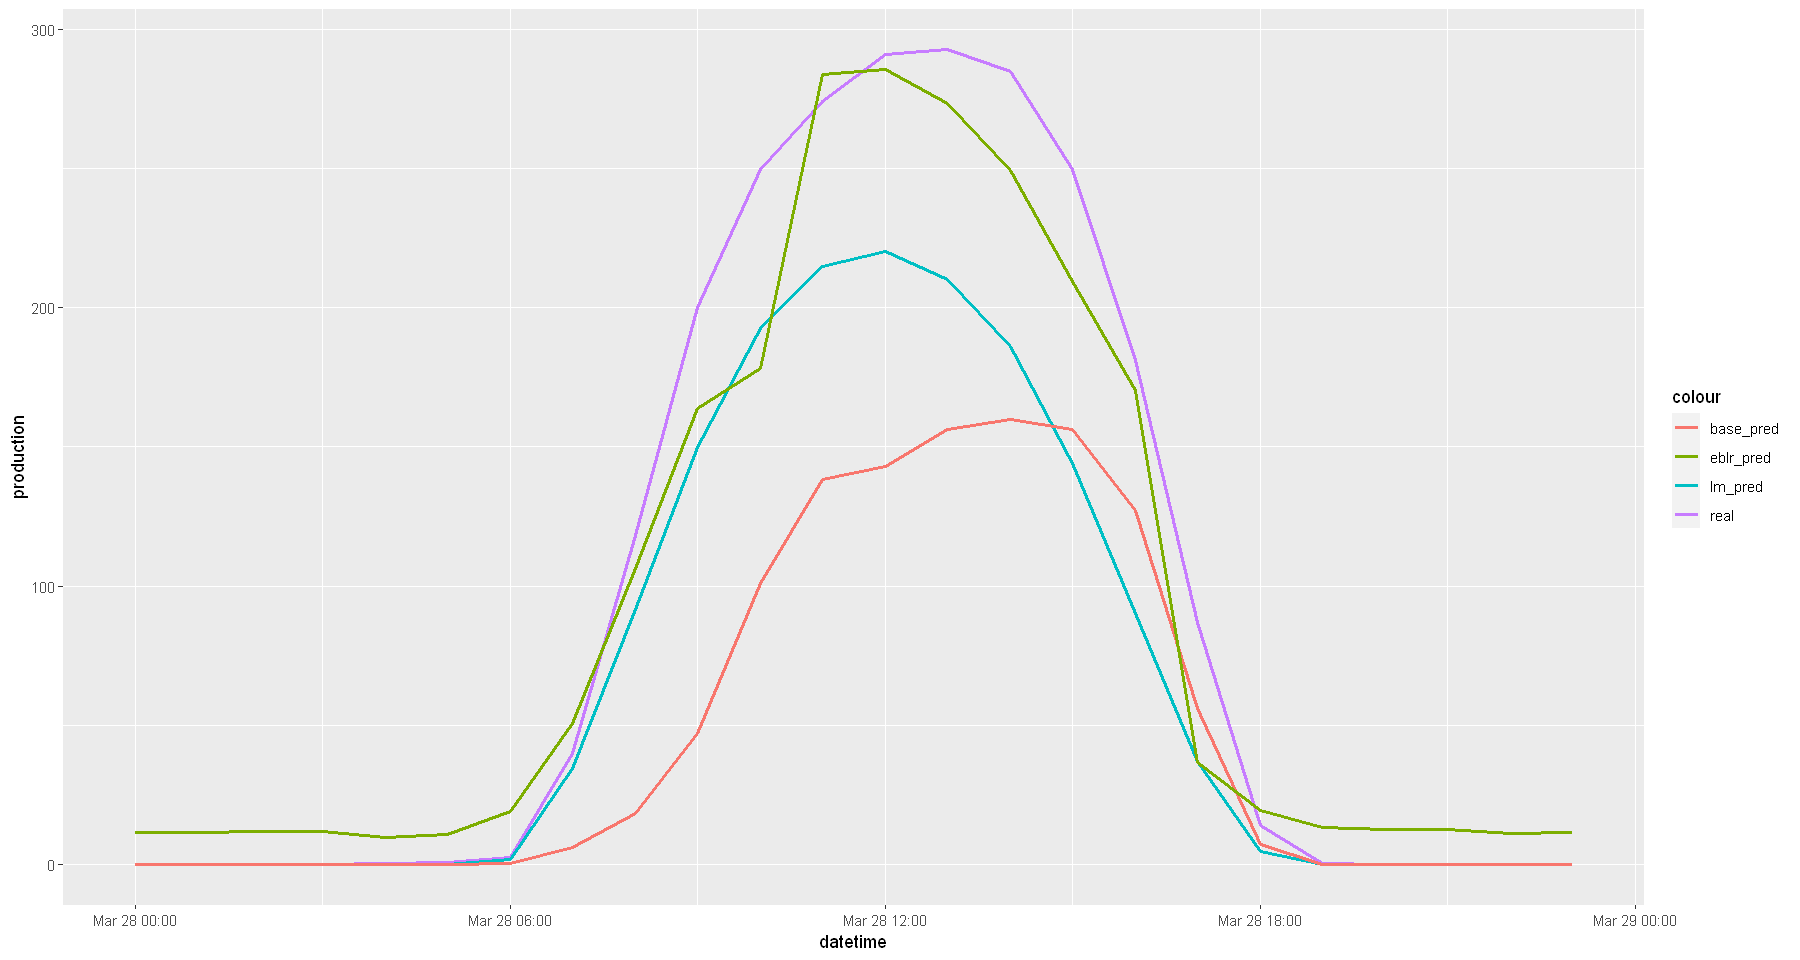

In [18]:
# check the date we make huge mistake after first eblr fit
ggplot(train_dat[date=="2021-03-28"] ,aes(x=datetime)) +
        geom_line(aes(y=production, color='real'), size=1) + 
        geom_line(aes(y=lm_base_prediction, color='lm_pred'), size=1) +
        geom_line(aes(y=base_prediction, color='base_pred'), size=1) + 
        geom_line(aes(y=lm_eblr_prediction_1, color='eblr_pred'), size=1) 

In [19]:
train_dat[,residual_eblr1:=production-lm_eblr_prediction_1]

# create formula
variables = colnames(train_dat[, -c("date", "production", "datetime","base_prediction", "trend", "lm_base_prediction", "residual_base", "lm_eblr_prediction_1")])
formula = as.formula(paste("residual_eblr1", 
            paste(variables, collapse = " + "), 
            sep = " ~ "))
    
# fit regression tree on residuals
fit_res_tree = rpart(formula, train_dat, control=rpart.control(cp=0, maxdepth=4))

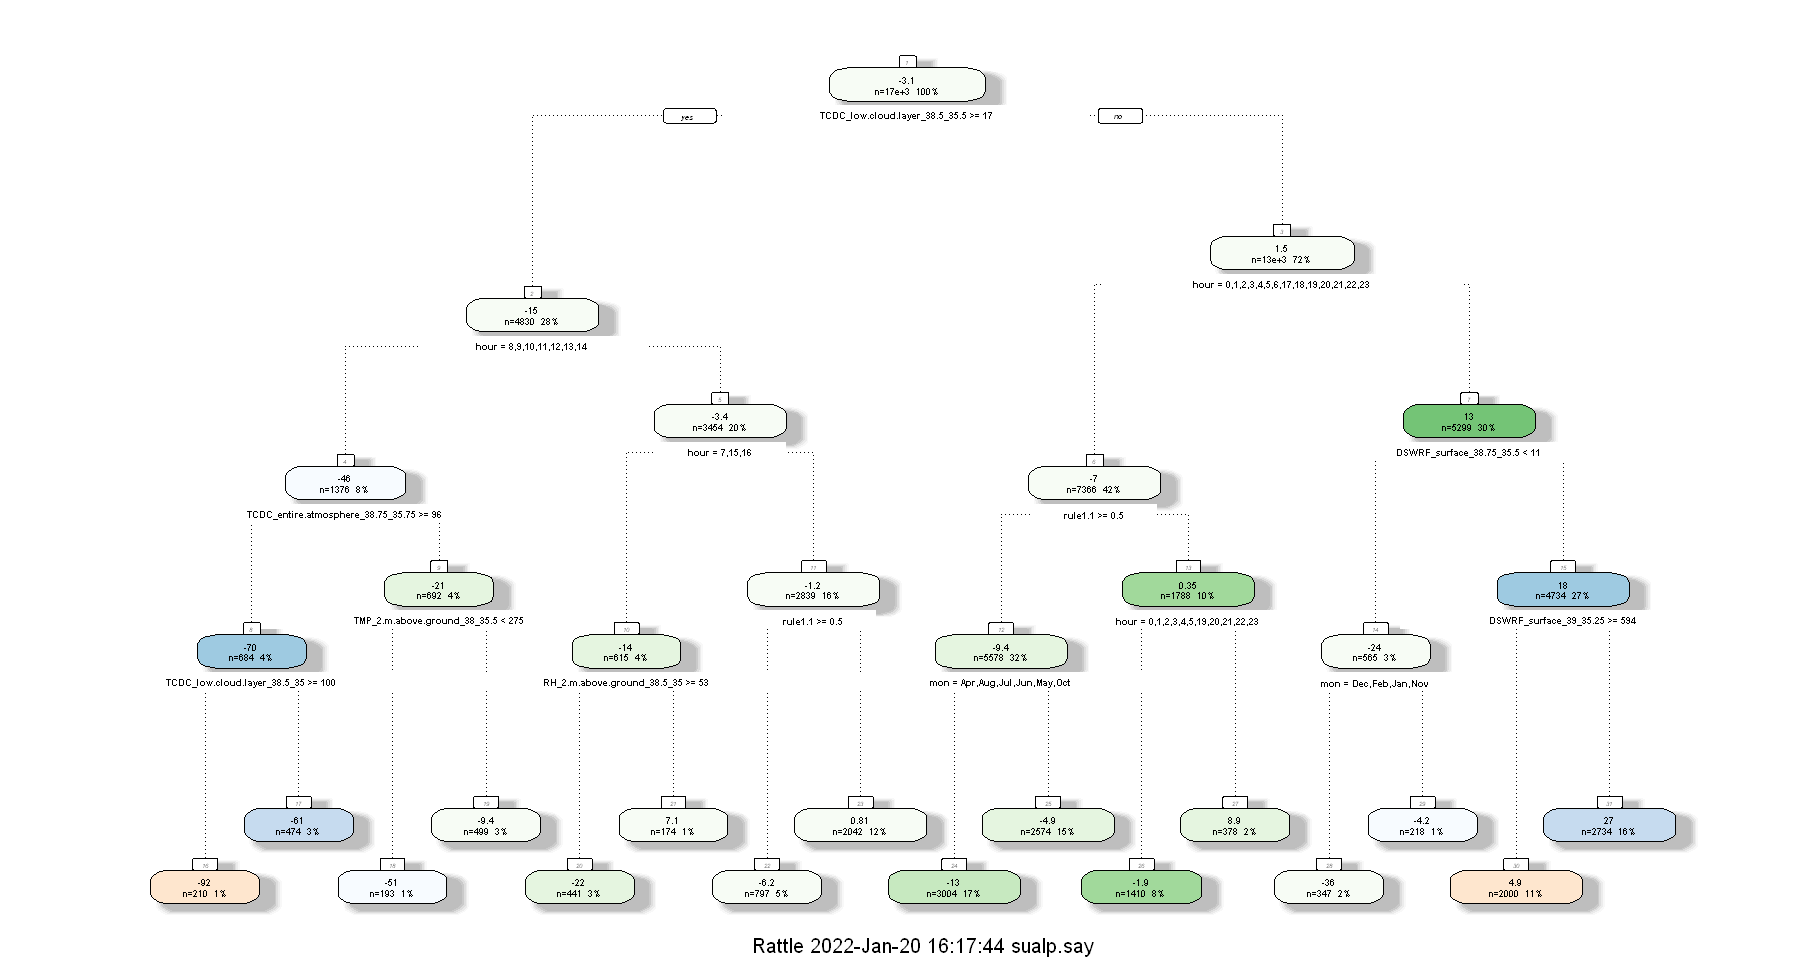

In [20]:
fancyRpartPlot(fit_res_tree)

###### Rules for terminal nodes with the largest absolute error: TCDC_low.cloud.layer_38.5_35.5>=17, hour=8,9,10,11,12,13,14, TCDC_entire.atmosphere_38.75_35.75>=96, TCDC_low.cloud.layer_38.5_35>=100

In [21]:
train_dat[,rule2:=as.numeric(TCDC_low.cloud.layer_38.5_35.5>=17)]
train_dat[,rule2.1:=as.numeric((hour %in% c(8,9,10,11,12,13,14)))]
train_dat[,rule2.2:=as.numeric(TCDC_entire.atmosphere_38.75_35.75>=96)]
train_dat[,rule2.3:=as.numeric(TCDC_low.cloud.layer_38.5_35>=100)]

lm_eblr_2 = lm(production ~ trend + w_day + mon + hour+rule1*rule1.1*rule1.2*rule1.3+rule2*rule2.1*rule2.2*rule2.3, train_dat)
train_dat[,lm_eblr_prediction_2:=predict(lm_eblr_2, train_dat)]
train_dat[,lm_eblr_prediction_2:=ifelse(lm_eblr_prediction_2<0, 0, lm_eblr_prediction_2)]

In [22]:
# see performance of the eblr model, in terms of provided measure
performance = train_dat[,list(daily_production=sum(production),
                              daily_prediction=sum(lm_eblr_prediction_2),
                              daily_residual=sum(production)-sum(lm_eblr_prediction_2)), "date"]

performance[,ape:=abs(daily_residual)/daily_production]
print(sprintf("current wmape: %.3f percent", 100*sum(abs(performance$daily_residual))/sum(performance$daily_production)))

[1] "current wmape: 11.421 percent"


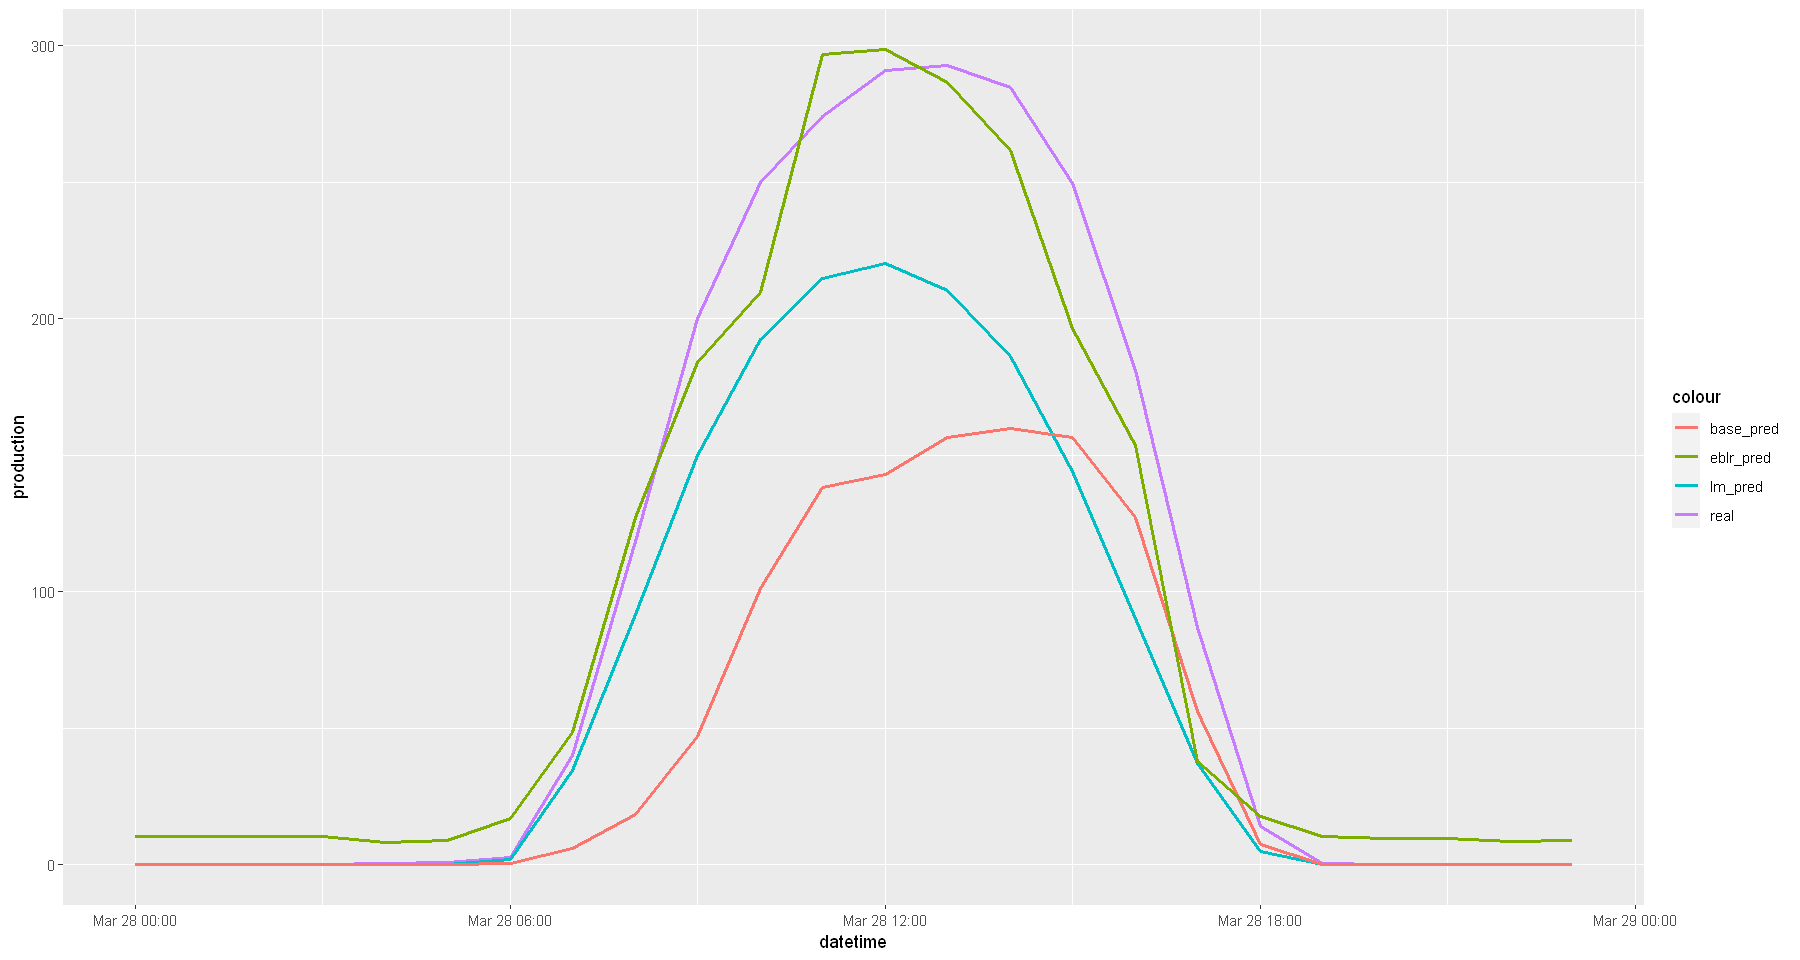

In [23]:
# check the date we make huge mistake after first eblr fit
ggplot(train_dat[date=="2021-03-28"] ,aes(x=datetime)) +
        geom_line(aes(y=production, color='real'), size=1) + 
        geom_line(aes(y=lm_base_prediction, color='lm_pred'), size=1) +
        geom_line(aes(y=base_prediction, color='base_pred'), size=1) + 
        geom_line(aes(y=lm_eblr_prediction_2, color='eblr_pred'), size=1)

In [24]:
train_dat[,residual_eblr2:=production-lm_eblr_prediction_2]

# create formula
variables = colnames(train_dat[, -c("date", "production", "datetime","base_prediction", "trend", "lm_base_prediction", "residual_base", "lm_eblr_prediction_1", "residual_eblr1", "lm_eblr_prediction_2")])
formula = as.formula(paste("residual_eblr2", 
            paste(variables, collapse = " + "), 
            sep = " ~ "))
    
# fit regression tree on residuals
fit_res_tree = rpart(formula, train_dat, control=rpart.control(cp=0, maxdepth=4))

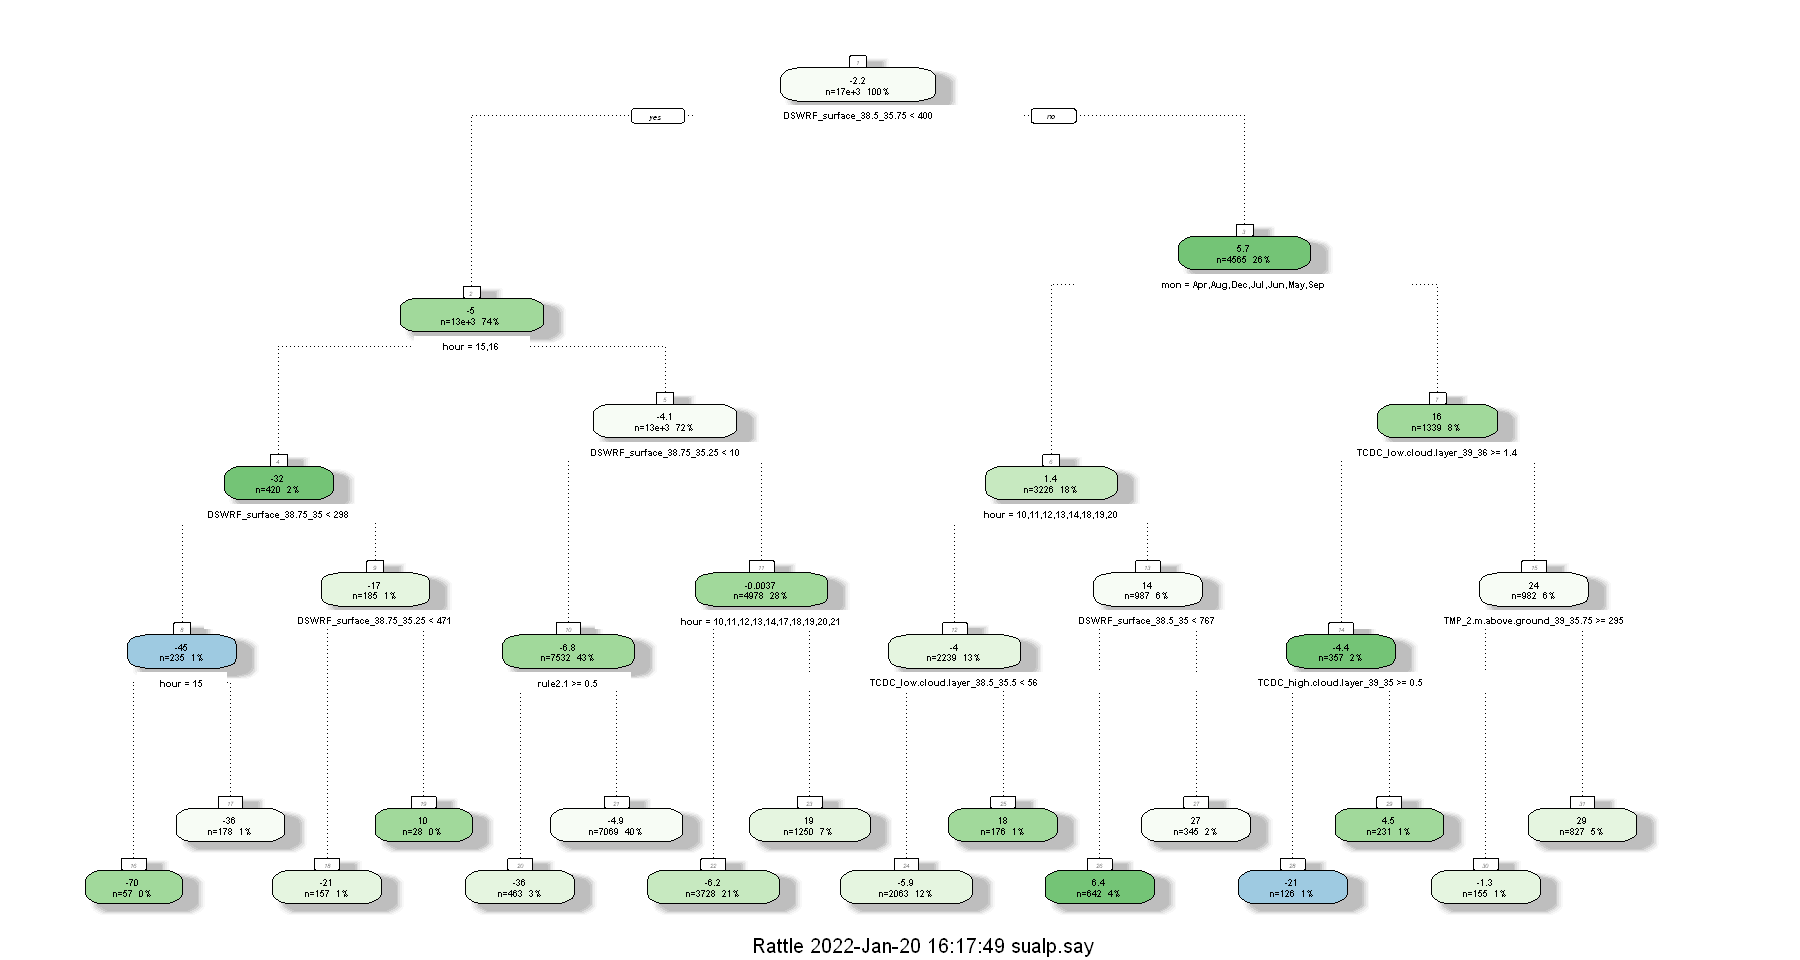

In [25]:
fancyRpartPlot(fit_res_tree)

###### Rules for terminal nodes with the largest absolute error: DSWRF_surface_38.5_35.75<400, hour!=15, 16, DSWRF_surface_38.5_35.75<10, rule2.1<0.5

In [26]:
train_dat[,rule3:=as.numeric(DSWRF_surface_38.5_35.75<400)]
train_dat[,rule3.1:=as.numeric(!(hour %in% c(15,16)))]
train_dat[,rule3.2:=as.numeric(DSWRF_surface_38.5_35.75<10)]
train_dat[,rule3.3:=as.numeric(rule2.1<0.5)]

lm_eblr_3 = lm(production ~ trend + w_day + mon + hour+rule1*rule1.1*rule1.2*rule1.3+rule2*rule2.1*rule2.2*rule2.3+rule3*rule3.1*rule3.2*rule3.3, train_dat)
train_dat[,lm_eblr_prediction_3:=predict(lm_eblr_3, train_dat)]
train_dat[,lm_eblr_prediction_3:=ifelse(lm_eblr_prediction_3<0, 0, lm_eblr_prediction_3)]

In [27]:
# see performance of the eblr model, in terms of provided measure
performance = train_dat[,list(daily_production=sum(production),
                              daily_prediction=sum(lm_eblr_prediction_3),
                              daily_residual=sum(production)-sum(lm_eblr_prediction_3)), "date"]

performance[,ape:=abs(daily_residual)/daily_production]
print(sprintf("current wmape: %.3f percent", 100*sum(abs(performance$daily_residual))/sum(performance$daily_production)))

[1] "current wmape: 10.522 percent"


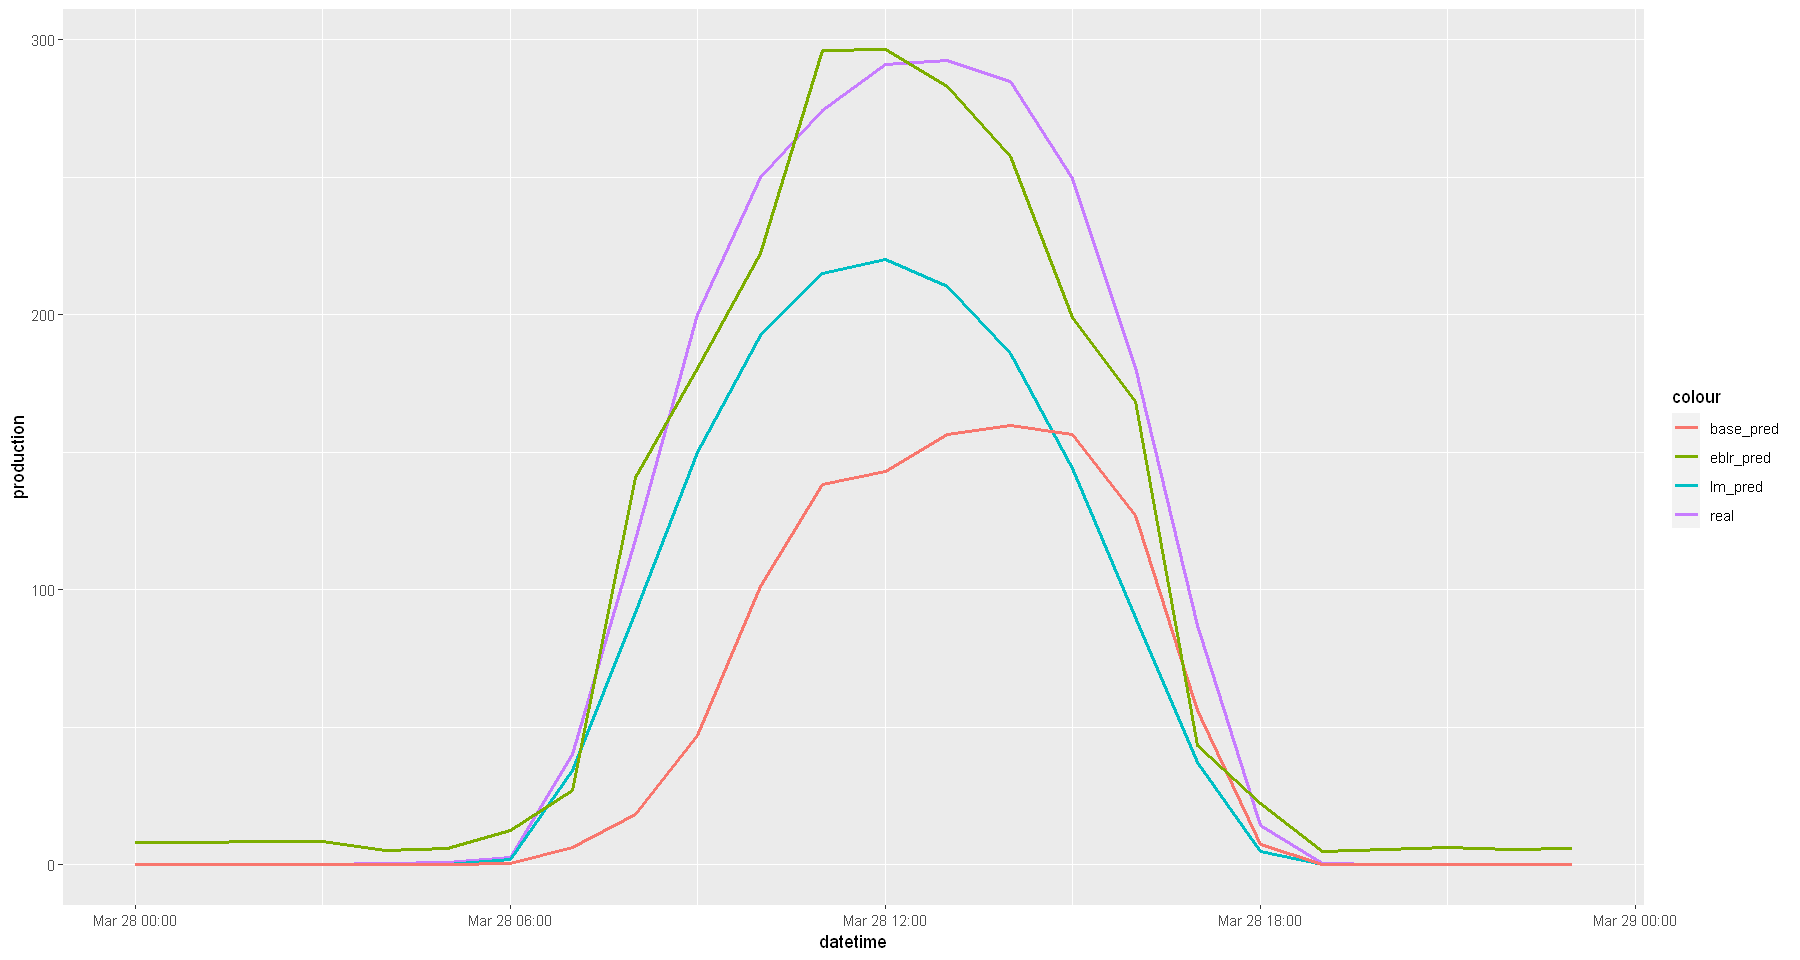

In [28]:
# check the date we make huge mistake after first eblr fit
ggplot(train_dat[date=="2021-03-28"] ,aes(x=datetime)) +
        geom_line(aes(y=production, color='real'), size=1) + 
        geom_line(aes(y=lm_base_prediction, color='lm_pred'), size=1) +
        geom_line(aes(y=base_prediction, color='base_pred'), size=1) + 
        geom_line(aes(y=lm_eblr_prediction_3, color='eblr_pred'), size=1)

In [29]:
train_dat[,residual_eblr3:=production-lm_eblr_prediction_3]

# create formula
variables = colnames(train_dat[, -c("date", "production", "datetime","base_prediction", "trend", "lm_base_prediction", "residual_base", "lm_eblr_prediction_1", "residual_eblr1", "lm_eblr_prediction_2", "residual_eblr2", "lm_eblr_prediction_3")])
formula = as.formula(paste("residual_eblr3", 
            paste(variables, collapse = " + "), 
            sep = " ~ "))
    
# fit regression tree on residuals
fit_res_tree = rpart(formula, train_dat, control=rpart.control(cp=0, maxdepth=4))

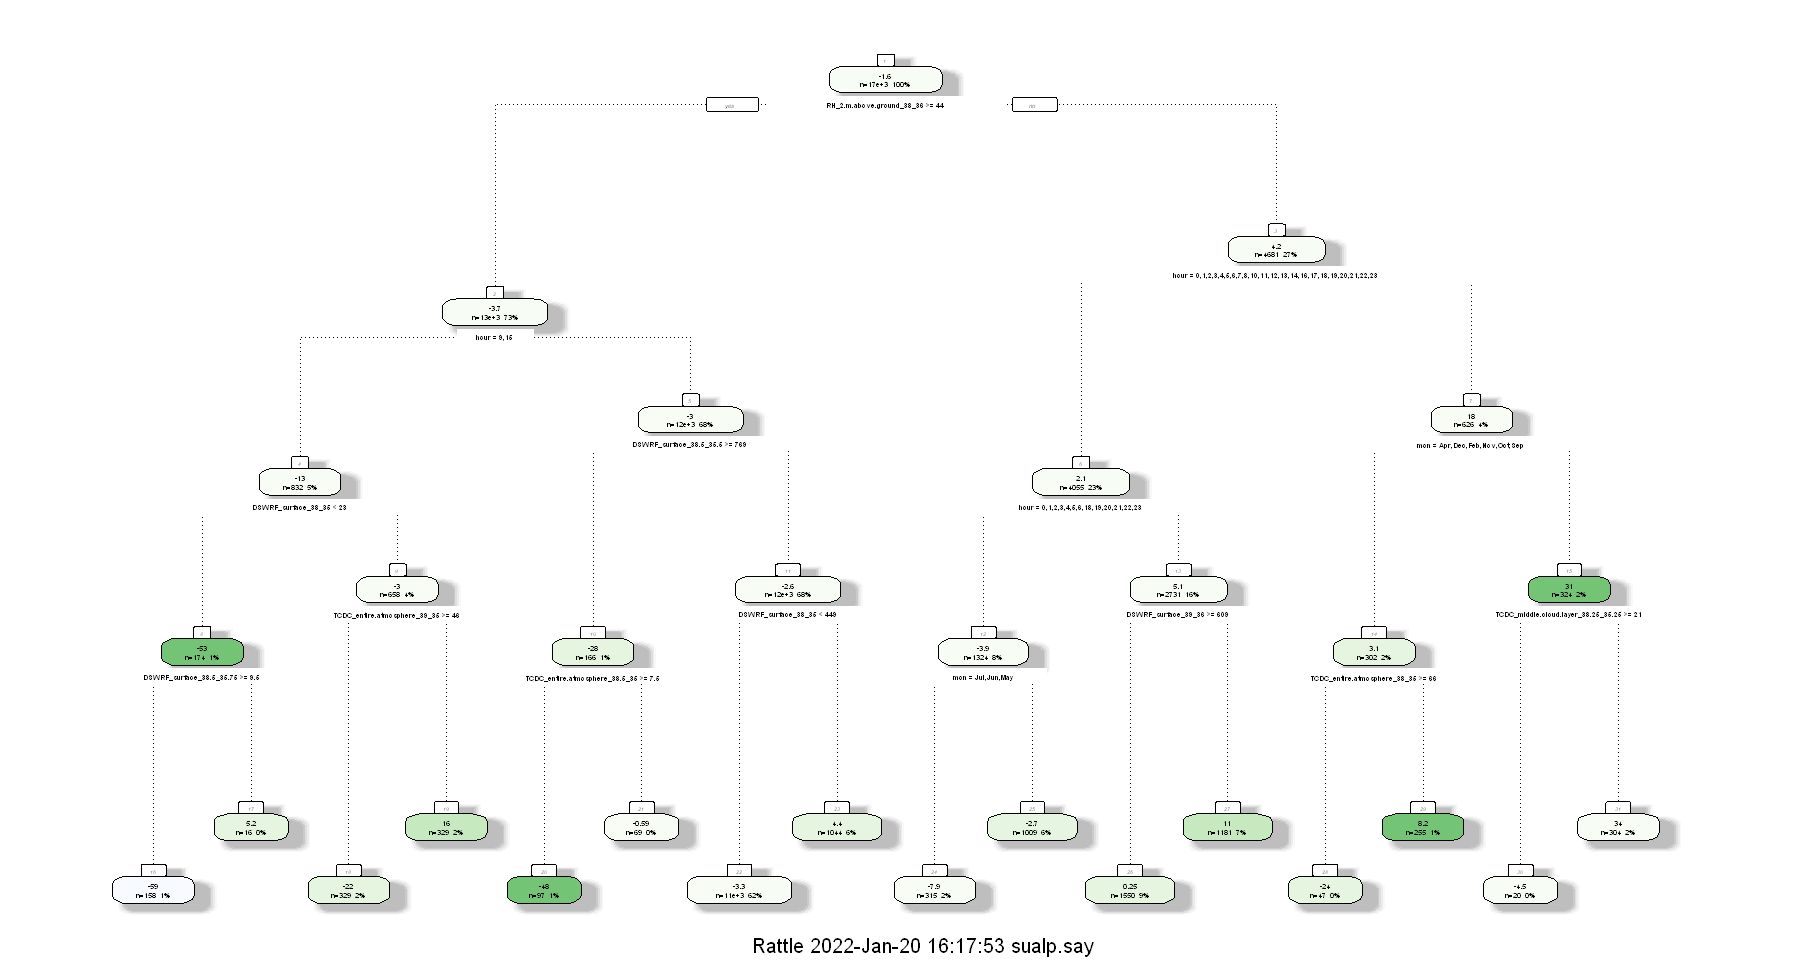

In [30]:
fancyRpartPlot(fit_res_tree)

In [31]:
train_dat[,rule4:=as.numeric(RH_2.m.above.ground_38_36>=44)]
train_dat[,rule4.1:=as.numeric(!(hour %in% c(9,15)))]
train_dat[,rule4.2:=as.numeric(DSWRF_surface_38.5_35.5>=769)]
train_dat[,rule4.3:=as.numeric(TCDC_entire.atmosphere_38.5_35>=7.5)]

lm_eblr_4 = lm(production ~ trend + w_day + mon + hour+rule1*rule1.1*rule1.2*rule1.3+rule2*rule2.1*rule2.2*rule2.3+rule3*rule3.1*rule3.2*rule3.3+rule4*rule4.1*rule4.2*rule4.3, train_dat)
train_dat[,lm_eblr_prediction_4:=predict(lm_eblr_4, train_dat)]
train_dat[,lm_eblr_prediction_4:=ifelse(lm_eblr_prediction_4<0, 0, lm_eblr_prediction_4)]

In [32]:
# see performance of the eblr model, in terms of provided measure
performance = train_dat[,list(daily_production=sum(production),
                              daily_prediction=sum(lm_eblr_prediction_4),
                              daily_residual=sum(production)-sum(lm_eblr_prediction_4)), "date"]

performance[,ape:=abs(daily_residual)/daily_production]
print(sprintf("current wmape: %.3f percent", 100*sum(abs(performance$daily_residual))/sum(performance$daily_production)))

[1] "current wmape: 9.882 percent"


###### Since the change in wmape is less than 1%, I stopped here and will predict the test data with lm_eblr_4 model

In [33]:
eblr_models = list()
eblr_predictions = list()

# preprocess the data to model
dat[,rule1:=as.numeric(DSWRF_surface_39_35.25>=589)]
dat[,rule1.1:=as.numeric(TCDC_middle.cloud.layer_38.75_35.25<2)]
dat[,rule1.2:=as.numeric(DSWRF_surface_38.25_36>=621)]
dat[,rule1.3:=as.numeric(!(mon %in% c('Jul', 'Jun', 'Oct', 'Sep')))]

dat[,rule2:=as.numeric(TCDC_low.cloud.layer_38.5_35.5>=17)]
dat[,rule2.1:=as.numeric((hour %in% c(8,9,10,11,12,13,14)))]
dat[,rule2.2:=as.numeric(TCDC_entire.atmosphere_38.75_35.75>=96)]
dat[,rule2.3:=as.numeric(TCDC_low.cloud.layer_38.5_35>=100)]

dat[,rule3:=as.numeric(DSWRF_surface_38.5_35.75<400)]
dat[,rule3.1:=as.numeric(!(hour %in% c(15,16)))]
dat[,rule3.2:=as.numeric(DSWRF_surface_38.5_35.75<10)]
dat[,rule3.3:=as.numeric(rule2.1<0.5)]

dat[,rule4:=as.numeric(RH_2.m.above.ground_38_36>=44)]
dat[,rule4.1:=as.numeric(!(hour %in% c(9,15)))]
dat[,rule4.2:=as.numeric(DSWRF_surface_38.5_35.5>=769)]
dat[,rule4.3:=as.numeric(TCDC_entire.atmosphere_38.5_35>=7.5)]


iter=1
for (day in unique(dat[date>="2021-11-01",]$date)){
            
    # suppose you are at day d and the predictions are needed for day d+1 and you know the production values until the end of d-1
    train_dat = dat[date<as.Date(day)-2]
    test_dat = dat[date==as.Date(day)]
    
    # model data
    lm_eblr = lm(production ~ trend + w_day + mon + hour+rule1*rule1.1*rule1.2*rule1.3+rule2*rule2.1*rule2.2*rule2.3+rule3*rule3.1*rule3.2*rule3.3+rule4*rule4.1*rule4.2*rule4.3, train_dat)
    test_dat[,lm_eblr_prediction:=predict(lm_eblr, test_dat)]
    test_dat[,lm_eblr_prediction:=ifelse(lm_eblr_prediction<0, 0, lm_eblr_prediction)]
    
    # store models and predictions
    eblr_models[[iter]] = lm_eblr
    eblr_predictions[[iter]] = test_dat
    iter=iter+1
    
}

fitted_values_eblr = do.call(rbind, eblr_predictions)
fitted_values_eblr = fitted_values_eblr[,c("date", "datetime", "hour", "lm_eblr_prediction")]

In [34]:
fitted_values = merge(fitted_values_lm, fitted_values_eblr, by=c("date", "datetime", "hour"), all.x=TRUE)

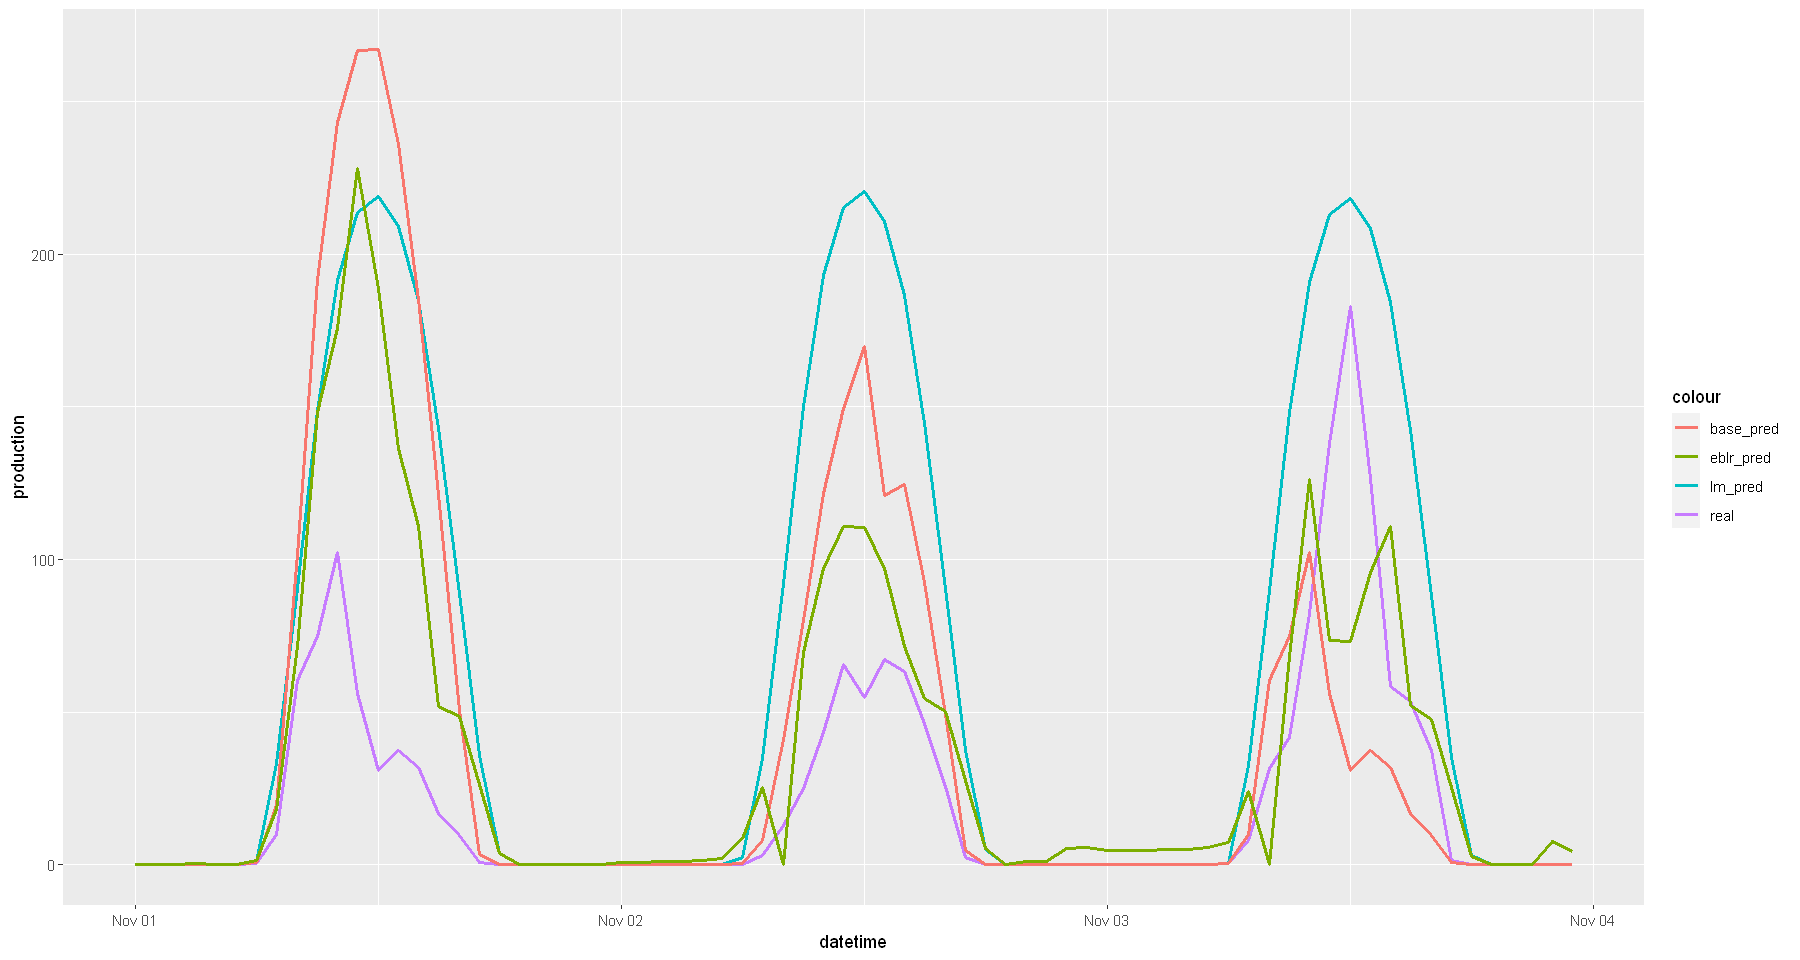

In [35]:
# visualize the three days prediction
ggplot(fitted_values[date>="2021-11-01"&date<="2021-11-03",] ,aes(x=datetime)) +
        geom_line(aes(y=production, color='real'), size=1) + 
        geom_line(aes(y=lm_base_prediction, color='lm_pred'), size=1) +
        geom_line(aes(y=base_prediction, color='base_pred'), size=1) + 
        geom_line(aes(y=lm_eblr_prediction, color='eblr_pred'), size=1) 

In [36]:
# see performance of all models
performance = fitted_values[,list(daily_production=sum(production),
                                  daily_base_prediction=sum(base_prediction),
                                  daily_lm_prediction=sum(lm_base_prediction),
                                  daily_eblr_prediction=sum(lm_eblr_prediction),
                                  daily_residual_base=sum(production)-sum(base_prediction),
                                  daily_residual_lm=sum(production)-sum(lm_base_prediction),
                                  daily_residual_eblr=sum(production)-sum(lm_eblr_prediction)), "date"]

performance[,ape_base:=abs(daily_residual_base)/daily_production]
performance[,ape_lm:=abs(daily_residual_lm)/daily_production]
performance[,ape_eblr:=abs(daily_residual_eblr)/daily_production]

print(sprintf("wmape of base: %.3f percent", 100*sum(abs(performance$daily_residual_base))/sum(performance$daily_production)))
print(sprintf("wmape of lm base: %.3f percent", 100*sum(abs(performance$daily_residual_lm))/sum(performance$daily_production)))
print(sprintf("wmape of lm after eblr: %.3f percent", 100*sum(abs(performance$daily_residual_eblr))/sum(performance$daily_production)))

[1] "wmape of base: 44.995 percent"
[1] "wmape of lm base: 45.503 percent"
[1] "wmape of lm after eblr: 17.664 percent"


### Discussion

##### First and third tree implies that base lm model makes huge mistakes when there is a very high or very low DSWR value. It makes sence because as it is proposed in the explanation that DSWR is known to be highly related to the production level and it is okay to make mistakes when this value is high or low.  In the same manner, from the overall data one can expect that the production increases in day time, but cloud  may cause it to decrase. Probably  the second tree covers this relation. It is saying that when there is so much cloud in low layer, there might be huge decreases in the main hours. 

###### When residuals are modeled with trees,  huge decrease in wmape can be seen by tracking it programatically. Even, after first tree, it decreased to 14.77% in train data. For the final results, as it is already printed above there is a significant decrease in wmape after using eblr approach in test data. 